<a name="topico4"></a>
# Bibliotecas


In [ ]:
# Instalar o CLIP a partir do repositório oficial do OpenAI
!pip install git+https://github.com/openai/CLIP.git
!pip install torchmetrics

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-om17mjbh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-om17mjbh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torchvision
import pickle
import clip
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import average_precision_score
from torchmetrics.retrieval import RetrievalMAP, RetrievalMRR, RetrievalPrecision, RetrievalRecall

<a name="topico4"></a>
# Extração e Exploração do Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Caminho da pasta no Google Drive
project_folder = '/content/drive/MyDrive/FM30k/'

# Caminhos dos arquivos
tar_gz_path = f'{project_folder}flickr30k-images.tar.gz'
captions_path = f'{project_folder}captions.txt'


In [ ]:
# import tarfile
# import os

# # Extrair o arquivo .tar.gz
# with tarfile.open(tar_gz_path, 'r:gz') as tar:
#     tar.extractall(path=project_folder)

# # Verificar os arquivos extraídos
# extracted_files = os.listdir(project_folder)
# print(f"Arquivos extraídos: {project_folder[:5]}")  # Mostrar os primeiros 5 arquivos extraídos


In [ ]:
# Ler o arquivo de captions
with open(captions_path, 'r') as f:
    captions = f.readlines()

# Mostrar as primeiras 5 captions
print(f"Primeiras captions: {captions[:5]}")

Primeiras captions: ['1000092795.jpg#1\tDois homens conversam no jardim perto do portão.\n', '1000092795.jpg#2\tDois jovens vestindo calças e camisetas encontram-se próximos a um portão cercados por uma área verde com muitas plantas e um gramado.\n', '1000092795.jpg#3\tDois homens vestindo calça e camisa de malha estão em pé em frente a um portão que dá acesso a um jardim.\n', '1000092795.jpg#4\tDois homens parados, em um ambiente aberto com folhagem verde, próximos a um portão de metal e vidro.\n', '1000092795.jpg#5\tDois homens em frente a um portão cercado de plantas.\n']


In [ ]:
# # Caminho para a pasta com as imagens
# image_folder = os.path.join(project_folder, "flickr30k-images")

# # Listar apenas arquivos de imagem
# image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

# # Mostrar a primeira imagem
# if image_files:
#     image_path = os.path.join(image_folder, image_files[0])  # Caminho completo da primeira imagem
#     image = Image.open(image_path)  # Abrir a imagem com Pillow

#     # Exibir a imagem
#     plt.figure(figsize=(6, 6))  # Tamanho da figura
#     plt.imshow(image)
#     plt.axis("off")  # Remover eixos
#     plt.title(f"Primeira Imagem: {image_files[0]}")  # Título com o nome do arquivo
#     plt.show()
# else:
#     print("Nenhuma imagem encontrada na pasta!")

<a name="topico4"></a>
# Organizando Imagens e legendas


In [ ]:
ja_feito_salvo_em_pickle = True

if not ja_feito_salvo_em_pickle:
  images_names = []

  # Ler as legendas do arquivo
  with open(captions_path, 'r') as f:
      for idx, line in enumerate(f.readlines()):  # Use o índice do loop para o índice das legendas
          line = line.strip()  # Remover espaços em branco nas extremidades
          if not line:  # Ignorar linhas vazias
              continue

          # Verificar se a linha contém duas tabulações para separar a imagem e a legenda
          parts = line.split('\t')

          # Separar a linha em partes (imagem, índice da legenda e o texto da legenda)
          image_name_index, caption_text = parts[0], parts[1]
          image_name_index_ = image_name_index.split('#')
          # Extrair nome da imagem e o índice da legenda
          image_name, index = image_name_index_[0], image_name_index_[1]

          images_names.append(image_name)

          image_index = images_names.index(image_name)


  # Exemplo de saída para verificação
  images_names

In [ ]:
if not ja_feito_salvo_em_pickle:
  # Lista para armazenar os arquivos únicos mantendo a ordem
  images_name_unique = []

  # Conjunto para verificar se o item já foi adicionado
  arquivos_vistos = set()

  # Iterando pelo vetor original
  for arquivo in images_names:
      if arquivo not in arquivos_vistos:
          images_name_unique.append(arquivo)
          arquivos_vistos.add(arquivo)

  path_name_vector = '/content/drive/MyDrive/FM30k/name_img_EN.pkl'

  with open(path_name_vector, 'wb') as file:
      pickle.dump(images_name_unique, file)

  print("Vetor salvo com sucesso usando pickle!")

In [ ]:
path_name_vector = '/content/drive/MyDrive/FM30k/name_img.pkl'
with open(path_name_vector, 'rb') as file:
    images_names = pickle.load(file)

print("Vetor images_names carregado com sucesso usando pickle!")
print(len(images_names))

Vetor images_names carregado com sucesso usando pickle!
31783


In [ ]:
if not ja_feito_salvo_em_pickle:
  image_captions = {}
  image_to_legend_indices = {}  # Dicionário que mapeia índice da imagem para índices das legendas
  all_legendas = []
  images_names = images_names

  # Ler as legendas do arquivo
  with open(captions_path, 'r') as f:
      for idx, line in enumerate(f.readlines()):  # Use o índice do loop para o índice das legendas
          line = line.strip()  # Remover espaços em branco nas extremidades
          if not line:  # Ignorar linhas vazias
              continue

          # Verificar se a linha contém duas tabulações para separar a imagem e a legenda
          parts = line.split('\t')

          # Separar a linha em partes (imagem, índice da legenda e o texto da legenda)
          image_name_index, caption_text = parts[0], parts[1]
          image_name_index_ = image_name_index.split('#')

          # Extrair nome da imagem e o índice da legenda
          image_name, index = image_name_index_[0], image_name_index_[1]
          index = int(index) - 1  # Ajusta para começar de 0

          # Adicionar o nome da imagem e a legenda nas listas
          all_legendas.append(caption_text)

          # Organizar as legendas em um dicionário, onde a chave é o nome da imagem
          if image_name not in image_captions:
              image_captions[image_name] = {}
          image_captions[image_name][index] = caption_text

          # Encontre o índice da imagem na lista `images_names` carregada anteriormente
          image_index = images_names.index(image_name)

          # Se o índice da imagem ainda não estiver no dicionário `image_to_legend_indices`, adicione uma lista vazia
          if image_index not in image_to_legend_indices:
              image_to_legend_indices[image_index] = []

          # Adicionar o índice da legenda (usando o índice do loop) à lista correspondente à imagem
          image_to_legend_indices[image_index].append(idx)

  # Exemplo de saída para verificação
  print(image_to_legend_indices)

  path_image_to_legend_indices = '/content/drive/MyDrive/FM30k/image_to_legend_indices_EN.pkl'
  with open(path_image_to_legend_indices, 'wb') as file:
        pickle.dump(image_to_legend_indices, file)

  path_all_legendas = '/content/drive/MyDrive/FM30k/all_legendas_en_to_pt_full.pkl'
  with open(path_all_legendas, 'wb') as file:
        pickle.dump(all_legendas, file)

In [ ]:
path_image_to_legend_indices = '/content/drive/MyDrive/FM30k/image_to_legend_indices_EN.pkl'
with open(path_image_to_legend_indices, 'rb') as file:
    image_to_legend_indices = pickle.load(file)

print("Dicionário image_to_legend_indices carregado com sucesso usando pickle!")
print(len(image_to_legend_indices))

Dicionário image_to_legend_indices carregado com sucesso usando pickle!
31783


In [ ]:
path_all_legendas = '/content/drive/MyDrive/FM30k/all_legendas_en_to_pt_full.pkl'
with open(path_all_legendas, 'rb') as file:
    all_legendas = pickle.load(file)

print("Vetor all_legendas carregado com sucesso usando pickle!")
print(len(all_legendas))

Vetor all_legendas carregado com sucesso usando pickle!
158914


<a name="topico4"></a>
# Subset Para Rodar Local

In [ ]:
num_imagens = 20

In [ ]:
images_names = images_names[:num_imagens]

In [ ]:
image_to_legend_indices = dict(list(image_to_legend_indices.items())[:num_imagens])

In [ ]:
all_legendas = all_legendas[:image_to_legend_indices[num_imagens-1][-1]+1]

In [ ]:
all_legendas

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young , White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .',
 'Several men in hard hats are operating a giant pulley system .',
 'Workers look down from up above on a piece of equipment .',
 'Two men working on a machine wearing hard hats .',
 'Four men on top of a tall structure .',
 'Three men on a large rig .',
 'A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl climbing into a wooden playhouse',
 'A girl going into a wooden building .',
 'Someone in a blue shirt and hat is standing on stair and leaning against a window .',
 'A man in a blue shirt is standing on a ladder cleaning a window .',
 'A m

In [ ]:
path_all_legendas = '/content/drive/MyDrive/FM30k/all_legendas_EN_100.pkl'
with open(path_all_legendas, 'wb') as file:
      pickle.dump(all_legendas, file)

<a name="topico4"></a>
# Divisão Dataset

In [ ]:
def generate_folds_pairs(image_indices, num_folds=5, seed=42):
    """
    Gera folds de validação cruzada com embaralhamento controlado.
    Retorna uma lista de pares (train_indices, val_indices) como no KFold.

    Parâmetros:
    - image_indices (list): Lista de nomes das imagens
    - num_folds (int): Número de folds (default: 5)
    - seed (int): Seed para embaralhamento reprodutível

    Retorna:
    - folds (list): Lista com tuplas (train_indices, val_indices)
    """
    # Gerar e embaralhar os índices
    image_indices = np.arange(len(image_indices))
    rng = np.random.default_rng(seed)
    rng.shuffle(image_indices)

    # Dividir em folds
    folds_split = np.array_split(image_indices, num_folds)

    # Criar lista de pares (train, val)
    folds = []
    for i in range(num_folds):
        val_indices = folds_split[i]
        train_indices = np.concatenate([folds_split[j] for j in range(num_folds) if j != i])
        folds.append((train_indices.tolist(), val_indices.tolist()))

    return folds



In [ ]:
num_folds = 5
seed = 42
np.random.seed(seed)

image_indices = np.arange(len(images_names))  # Lista [0, 1, 2, ..., 30999]
# Embaralhar os índices para garantir aleatoriedade
np.random.shuffle(image_indices)
image_indices

folds = generate_folds_pairs(image_indices, num_folds=num_folds, seed=seed)

fold_id = 0
train_indices, val_indices = folds[fold_id]

# Obter imagens correspondentes
train_images = [images_names[i] for i in train_indices]
val_images = [images_names[i] for i in val_indices]

# Obter as legendas correspondentes
train_legends = [all_legendas[idx] for i in train_indices for idx in image_to_legend_indices[i]]
val_legends = [all_legendas[idx] for i in val_indices for idx in image_to_legend_indices[i]]

<a name="topico4"></a>
# Finetuning

In [ ]:
base_finetuning = "ViT-B/32"
nome_salvar = f"{base_finetuning.replace('/', '-')}_seed{seed}_{fold_id}"

nome_salvar

'ViT-B-32_seed42_0'

<a name="topico4"></a>
### Carregando o CLIP e congelando o encoder visual

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(base_finetuning, device=device)

# Congelar a parte visual
for param in model.visual.parameters():
    param.requires_grad = False

# Otimizador só para a parte textual
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

loss_fn = torch.nn.CrossEntropyLoss()


<a name="topico4"></a>
### Montando dataset

In [ ]:
train_image_paths = []

for i in train_indices:
    image_path = images_names[i]
    legend_indices = image_to_legend_indices[i]
    for _ in legend_indices:
        train_image_paths.append(image_path)


In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, legends, preprocess, image_dir):
        self.image_paths = image_paths
        self.legends = legends
        self.preprocess = preprocess
        self.image_dir = image_dir

    def __len__(self):
        return len(self.legends)

    def __getitem__(self, idx):
        image_filename = self.image_paths[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        image = self.preprocess(Image.open(image_path).convert("RGB"))
        text = clip.tokenize([self.legends[idx]], truncate=True)[0].long()
        # text = self.legends[idx]
        return image, text



In [ ]:
image_folder = '/content/drive/MyDrive/FM30k/flickr30k-images'
train_dataset = CLIPDataset(train_image_paths, train_legends, preprocess, image_folder)

<a name="topico4"></a>
### Ver uma amostra aleatória do dataset

Exemplo 3920
Legenda: tensor([49406,  1008,  2143,   332,   654,  1004,  6536, 11656,   920, 34104,
         1140,  2291, 22229,  2270,  1008,   699,  2319,   269, 49407,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0])


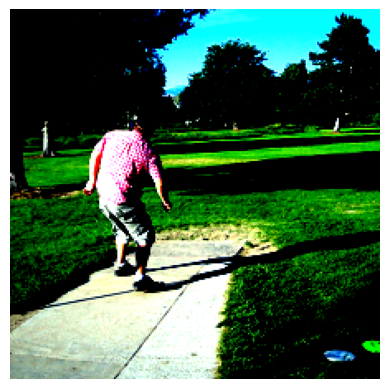

In [ ]:
idx = random.randint(0, len(train_dataset) - 1)
img, txt = train_dataset[idx]

print(f"Exemplo {idx}")
print("Legenda:", txt)
plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
plt.show()



<a name="topico4"></a>
### DataLoader

In [ ]:

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


<a name="topico4"></a>
### Loop de Treinamento

In [ ]:
from tqdm import tqdm

model.train()
model = model.float()
torch.autograd.set_detect_anomaly(True)

epochs = 3
eps = 1e-8

for epoch in range(epochs):
    total_loss = 0

    # Barra de progresso para a época
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")

    for batch_idx, (images, texts) in pbar:
        images = images.to(device).float()
        texts = texts.to(device)

        optimizer.zero_grad()

        image_features = model.encode_image(images)
        text_features = model.encode_text(texts)

        image_features = image_features / (image_features.norm(dim=-1, keepdim=True) + eps)
        text_features = text_features / (text_features.norm(dim=-1, keepdim=True) + eps)

        logits_per_image = image_features @ text_features.t()
        logits_per_text = text_features @ image_features.t()

        # ### VISUALIZAR HEATMAP DOS LOGITS
        # logits_np = logits_per_image.detach().cpu().numpy()
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(logits_np, annot=False, cmap="viridis")
        # plt.title("🔍 Heatmap dos Logits (Imagem → Texto)")
        # plt.xlabel("Legenda no batch")
        # plt.ylabel("Imagem no batch")
        # plt.show()

        # logits_np_text = logits_per_text.detach().cpu().numpy()
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(logits_np_text, annot=False, cmap="magma")
        # plt.title("🔍 Heatmap dos Logits (Texto → Imagem)")
        # plt.xlabel("Imagem no batch")
        # plt.ylabel("Legenda no batch")
        # plt.show()
        # ### VISUALIZAR HEATMAP DOS LOGITS

        labels = torch.arange(len(images), device=device)

        loss_img = loss_fn(logits_per_image, labels)
        loss_txt = loss_fn(logits_per_text, labels)
        loss = (loss_img + loss_txt) / 2

        # Verifica NaN ou Inf
        if torch.isnan(loss) or torch.isinf(loss):
            print("❌ Detected NaN ou Inf na loss!")
            print("Loss img:", loss_img.item(), "Loss txt:", loss_txt.item())
            break

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # 📋 Logs de diagnóstico formatados
        diag_log = (
            f"Loss: {loss.item():.4f} | "
            f"I_feat μ: {image_features.mean():.4f}, σ: {image_features.std():.4f} | "
            f"T_feat μ: {text_features.mean():.4f}, σ: {text_features.std():.4f} | "
            f"Logits I→T: {logits_per_image.min():.2f}/{logits_per_image.max():.2f}"
        )

        # Atualiza a barra com info
        pbar.set_postfix_str(diag_log)

        # (Opcional) Salvar log em arquivo
        # with open("training_logs.txt", "a") as f:
        #     f.write(f"[Epoch {epoch+1} | Batch {batch_idx}] {diag_log}\n")

    print(f"\n ✅ Epoch {epoch+1}/{epochs} - Loss total: {total_loss:.4f}")


Epoch 1/3: 100%|██████████| 125/125 [01:33<00:00,  1.33it/s, Loss: 3.1645 | I_feat μ: -0.0012, σ: 0.0442 | T_feat μ: -0.0006, σ: 0.0442 | Logits I→T: -0.23/0.50]



 ✅ Epoch 1/3 - Loss total: 403.3358


Epoch 2/3: 100%|██████████| 125/125 [01:34<00:00,  1.32it/s, Loss: 3.1107 | I_feat μ: -0.0008, σ: 0.0442 | T_feat μ: -0.0005, σ: 0.0442 | Logits I→T: -0.21/0.51]



 ✅ Epoch 2/3 - Loss total: 391.3862


Epoch 3/3: 100%|██████████| 125/125 [01:33<00:00,  1.34it/s, Loss: 3.0783 | I_feat μ: -0.0013, σ: 0.0442 | T_feat μ: -0.0002, σ: 0.0442 | Logits I→T: -0.22/0.54]


 ✅ Epoch 3/3 - Loss total: 386.3576


In [ ]:
finetuning_folder = '/content/drive/MyDrive/FM30k/Finetuning'
finetuning_filename = f"clip_finetuned_{nome_salvar}.pth"
finetuning_path = os.path.join(finetuning_folder, finetuning_filename)

# Salvar os pesos do modelo fine-tunado
torch.save(model.state_dict(), finetuning_path)
print(f"✅ Modelo {finetuning_filename} salvo em {finetuning_path}")

✅ Modelo clip_finetuned_ViT-B-32_seed42_0.pth salvo em /content/drive/MyDrive/FM30k/Finetuning/clip_finetuned_ViT-B-32_seed42_0.pth


<a name="topico4"></a>
# Embeddings para Validação

<a name="topico4"></a>
### Carregando o CLIP com fine-tuning

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load(base_finetuning, device=device)

# Carregar os pesos fine-tunados
finetuning_folder = '/content/drive/MyDrive/FM30k/Finetuning'
finetuning_filename = f"clip_finetuned_{nome_salvar}.pth"
finetuning_path = os.path.join(finetuning_folder, finetuning_filename)

model.load_state_dict(torch.load(finetuning_path, map_location=device))
model.eval()  # Modo avaliação (desliga dropout, batchnorm, etc.)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 128MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

Verificando se apenas a parte textual foi treinada

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # Carregar o modelo original (antes de carregar os pesos fine-tunados)
# model_original, _ = clip.load(base_finetuning, device=device)

# # Carregar os pesos fine-tunados
# finetuning_folder = '/content/drive/MyDrive/FM30k/Finetuning'
# finetuning_filename = f"clip_finetuned_{nome_salvar}.pth"
# finetuning_path = os.path.join(finetuning_folder, finetuning_filename)

# # Carregar o estado dos pesos fine-tunados no modelo
# state_dict = torch.load(finetuning_path, map_location=device)

# # Carregar os pesos fine-tunados no modelo
# model.load_state_dict(state_dict, strict=False)

# # Comparar todos os parâmetros
# for name, param in model.named_parameters():
#     original_param = model_original.state_dict().get(name)

#     # Se o parâmetro original existe no modelo, compara os valores
#     if original_param is not None:
#         finetuned_param = param.data

#         # Se os parâmetros forem diferentes, imprime o nome
#         if not torch.equal(original_param, finetuned_param):
#             print(f"Parâmetro modificado: {name}")
#         else:
#             print(f"Parâmetro igual: {name}")


<a name="topico4"></a>
### Carregando o CLIP original

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_original, preprocess_original = clip.load(base_finetuning, device=device)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 57.5MiB/s]


<a name="topico4"></a>
### Dataset e Dataloader para a validação

In [ ]:
class ImageOnlyDataset(Dataset):
    def __init__(self, image_paths, preprocess, image_dir):
        self.image_paths = image_paths  # Lista com nomes dos arquivos .jpg
        self.preprocess = preprocess
        self.image_dir = image_dir

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")
        return self.preprocess(image)


In [ ]:
class TextOnlyDataset(Dataset):
    def __init__(self, legends, tokenizer):
        self.legends = legends
        self.tokenizer = tokenizer  # clip.tokenize

    def __len__(self):
        return len(self.legends)

    def __getitem__(self, idx):
        tokens = self.tokenizer([self.legends[idx]], truncate=True)
        return tokens[0]

Finetuning

In [ ]:
image_folder = '/content/drive/MyDrive/FM30k/flickr30k-images'

image_dataset = ImageOnlyDataset(val_images, preprocess, image_folder)
image_loader = DataLoader(image_dataset, batch_size=32, shuffle=False)

text_dataset = TextOnlyDataset(val_legends, tokenizer=clip.tokenize)
text_loader = DataLoader(text_dataset, batch_size=32, shuffle=False)

Original

In [ ]:
image_folder = '/content/drive/MyDrive/FM30k/flickr30k-images'

image_dataset_original = ImageOnlyDataset(val_images, preprocess_original, image_folder)
image_loader_original = DataLoader(image_dataset_original, batch_size=32, shuffle=False)

text_dataset_original = TextOnlyDataset(val_legends, tokenizer=clip.tokenize)
text_loader_original = DataLoader(text_dataset_original, batch_size=32, shuffle=False)

<a name="topico4"></a>
### Geração dos Embeddings

In [ ]:
def generate_embeddings(model, dataloader, tipo='image'):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = batch.to(device)
            if tipo == 'image':
                features = model.encode_image(batch)
            else:
                features = model.encode_text(batch)

            features /= features.norm(dim=-1, keepdim=True)
            all_embeddings.append(features.cpu())

    return torch.cat(all_embeddings)

Finetuning

In [ ]:
image_embeddings = generate_embeddings(model, image_loader, tipo='image')
text_embeddings = generate_embeddings(model, text_loader, tipo='text')

save_path = '/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine'
# Salvar no disco
torch.save(image_embeddings, os.path.join(save_path, f'image_embeddings_val_{nome_salvar}.pt'))
torch.save(text_embeddings, os.path.join(save_path, f'text_embeddings_val_{nome_salvar}.pt'))

  1%|          | 2/199 [02:27<3:33:38, 65.07s/it] 

Original

In [ ]:
image_embeddings_original = generate_embeddings(model_original, image_loader_original, tipo='image')
text_embeddings_original = generate_embeddings(model_original, text_loader_original, tipo='text')

save_path = '/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original'
# Salvar no disco
torch.save(image_embeddings_original, os.path.join(save_path, f'image_embeddings_EN_val.pt'))
torch.save(text_embeddings_original, os.path.join(save_path, f'text_embeddings_EN.pt'))

100%|██████████| 94/94 [00:02<00:00, 37.16it/s]


RuntimeError: Parent directory /content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/image_embeddings_ViT-B does not exist.

<a name="topico4"></a>
# Validação

In [ ]:
val_legend_indices = []
for idx in val_indices:
    val_legend_indices.extend(image_to_legend_indices[idx])

len(val_legend_indices)

158915

<a name="topico4"></a>
## Automática

In [ ]:
def evaluate_retrieval(
    query_embeddings,
    candidate_embeddings,
    ground_truth_mapping,
    query_indices,
    k=5,
    batch_size=256,
    device=None,
    mode="im2text"  # ou "text2im"
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)

    print(f"📡 Usando device: {device}")

    query_embeddings = query_embeddings.to(device)
    candidate_embeddings = candidate_embeddings.to(device)

    total_queries = len(query_indices)

    y_true_all = []
    y_score_all = []
    indexes_all = []   # NOVO

    for batch_start in range(0, total_queries, batch_size):
        batch = query_embeddings[batch_start: batch_start + batch_size]

        similarity = batch @ candidate_embeddings.T

        batch_size_real = similarity.size(0)

        for j in range(batch_size_real):
            query_idx_global = query_indices[batch_start + j]

            if mode == "im2text":
                ground_truth_set = set(ground_truth_mapping[query_idx_global])
                for idx_candidato in range(similarity.size(1)):
                    is_relevant = 1 if idx_candidato in ground_truth_set else 0
                    y_true_all.append(is_relevant)
                    y_score_all.append(similarity[j, idx_candidato].item())
                    indexes_all.append(batch_start + j)  # importante!

            elif mode == "text2im":
                imagem_idx_gt = None
                for imagem_idx, legendas_idx_list in ground_truth_mapping.items():
                    if query_idx_global in legendas_idx_list:
                        imagem_idx_gt = imagem_idx
                        break
                if imagem_idx_gt is None:
                    continue
                for idx_candidato in range(similarity.size(1)):
                    is_relevant = 1 if idx_candidato == imagem_idx_gt else 0
                    y_true_all.append(is_relevant)
                    y_score_all.append(similarity[j, idx_candidato].item())
                    indexes_all.append(batch_start + j)  # importante!

            else:
                raise ValueError(f"Modo inválido: {mode}. Use 'im2text' ou 'text2im'.")

    y_true_tensor = torch.tensor(y_true_all, dtype=torch.int, device=device)
    y_score_tensor = torch.tensor(y_score_all, dtype=torch.float, device=device)
    indexes_tensor = torch.tensor(indexes_all, dtype=torch.long, device=device)  # NOVO

    # === Métricas automáticas ===
    map_sklearn = average_precision_score(y_true_tensor.cpu(), y_score_tensor.cpu())

    map_metric = RetrievalMAP()
    mrr_metric = RetrievalMRR()
    precision_metric = RetrievalPrecision(top_k=k)
    recall_metric = RetrievalRecall(top_k=k)

    # 🛠️ Aqui o ajuste: passar o indexes_tensor
    map_value = map_metric(y_score_tensor, y_true_tensor, indexes=indexes_tensor).item()
    mrr_value = mrr_metric(y_score_tensor, y_true_tensor, indexes=indexes_tensor).item()
    precision_at_k_value = precision_metric(y_score_tensor, y_true_tensor, indexes=indexes_tensor).item()
    recall_at_k_value = recall_metric(y_score_tensor, y_true_tensor, indexes=indexes_tensor).item()

    if precision_at_k_value + recall_at_k_value > 0:
        f1_at_k_value = (2 * precision_at_k_value * recall_at_k_value) / (precision_at_k_value + recall_at_k_value)
    else:
        f1_at_k_value = 0.0

    print(f"✅ mAP (sklearn): {map_sklearn:.4f}")
    print(f"✅ mAP (torchmetrics): {map_value:.4f}")
    print(f"✅ MRR: {mrr_value:.4f}")
    print(f"✅ Precision@{k}: {precision_at_k_value:.4f}")
    print(f"✅ Recall@{k}: {recall_at_k_value:.4f}")
    print(f"✅ F1-Score@{k}: {f1_at_k_value:.4f}")

    return {
        "map_sklearn": map_sklearn,
        "map_torchmetrics": map_value,
        "mrr": mrr_value,
        "precision@k": precision_at_k_value,
        "recall@k": recall_at_k_value,
        "f1@k": f1_at_k_value,
    }


In [ ]:
image_embeddings = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine/image_embeddings_val.pt')
text_embeddings = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine/text_embeddings_val.pt')

In [ ]:
image_embeddings_original = torch.load(f'/content/drive/MyDrive/FM30k/Embeddings_EN/image_embeddings_full.pt')
text_embeddings_original = torch.load(f'/content/drive/MyDrive/FM30k/Embeddings_EN/text_embeddings_full.pt')

In [ ]:
image_embeddings_EN = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/image_embeddings_EN_val.pt')
text_embeddings_EN = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/text_embeddings_EN.pt')

In [ ]:
results = evaluate_retrieval(
    query_embeddings=image_embeddings_EN,
    candidate_embeddings=text_embeddings_EN,
    ground_truth_mapping=image_to_legend_indices,
    query_indices=val_indices,
    mode="im2text"
)

📡 Usando device: cuda
✅ mAP (sklearn): 0.0004
✅ mAP (torchmetrics): 0.0008
✅ MRR: 0.0009
✅ Precision@5: 0.0000
✅ Recall@5: 0.0000
✅ F1-Score@5: 0.0000


In [ ]:
results = evaluate_retrieval(
    query_embeddings=text_embeddings_EN,
    candidate_embeddings=image_embeddings_EN,
    ground_truth_mapping=image_to_legend_indices,
    query_indices=val_legend_indices,
    mode="text2im"
)


📡 Usando device: cuda
✅ mAP (sklearn): 0.0003
✅ mAP (torchmetrics): 0.0022
✅ MRR: 0.0022
✅ Precision@5: 0.0001
✅ Recall@5: 0.0007
✅ F1-Score@5: 0.0002


In [ ]:
results = evaluate_retrieval(
    query_embeddings=text_embeddings_original,
    candidate_embeddings=image_embeddings_original,
    ground_truth_mapping=image_to_legend_indices,
    query_indices=val_legend_indices,
    mode="text2im"
)

<a name="topico4"></a>
## Manual

In [ ]:
def evaluate_fold_image_to_text(
    val_indices,
    image_embeddings_val,
    text_embeddings_val,
    all_legendas,
    image_to_legend_indices,
    val_legend_indices,
    k=5,
    batch_size=256
                  ):
    total_images = len(val_indices)

    correct_count = 0
    average_precisions = []
    precision_at_k_sum = 0.0
    recall_at_k_sum = 0.0
    reciprocal_ranks = []

    for batch_start in range(0, total_images, batch_size):
        batch = image_embeddings_val[batch_start: batch_start + batch_size]

        # Similaridade entre batch de imagens e todas as legendas de validação
        similarity = batch @ text_embeddings_val.T
        topk_indices = torch.topk(similarity, k=k, dim=1).indices.cpu().tolist()

        for j, indices in enumerate(topk_indices):
            image_idx = val_indices[batch_start + j]  # índice original da imagem
            ground_truth = set(image_to_legend_indices[image_idx])

            # Métricas
            # indices são os indices locais, 0 do text_embeddings pode ser a legenda global 250
            # (val_legend_indices mapeia os índices locais para globais)
            if any(val_legend_indices[idx] in ground_truth for idx in indices):
                correct_count += 1

            relevant_count = 0
            precision_sum = 0.0
            for rank, idx in enumerate(indices):
                legend_idx_global = val_legend_indices[idx]
                if legend_idx_global in ground_truth:
                    relevant_count += 1
                    precision_sum += relevant_count / (rank + 1)

            average_precision = precision_sum / min(len(ground_truth), k) if ground_truth else 0
            average_precisions.append(average_precision)

            precision_at_k = sum(1 for idx in indices if val_legend_indices[idx] in ground_truth) / k
            precision_at_k_sum += precision_at_k

            recall_at_k = sum(1 for idx in indices if val_legend_indices[idx] in ground_truth) / len(ground_truth)
            recall_at_k_sum += recall_at_k

            reciprocal_rank = 0.0
            for rank, idx in enumerate(indices):
                if val_legend_indices[idx] in ground_truth:
                    reciprocal_rank = 1.0 / (rank + 1)
                    break
            reciprocal_ranks.append(reciprocal_rank)

    # Resultados finais
    top5_accuracy = correct_count / total_images
    mean_average_precision = sum(average_precisions) / total_images
    precision_at_k = precision_at_k_sum / total_images
    recall_at_k = recall_at_k_sum / total_images
    mean_reciprocal_rank = sum(reciprocal_ranks) / total_images
    f1_score_at_k = (2 * precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) > 0 else 0.0

    print(f"(Imagem ➔ Texto)")
    print(f"✅ Top-5 Accuracy: {top5_accuracy:.4f}")
    print(f"✅ mAP: {mean_average_precision:.4f}")
    print(f"✅ Precision@{k}: {precision_at_k:.4f}")
    print(f"✅ Recall@{k}: {recall_at_k:.4f}")
    print(f"✅ MRR: {mean_reciprocal_rank:.4f}")
    print(f"✅ F1-Score@{k}: {f1_score_at_k:.4f}")

    return {
        "top5_accuracy": top5_accuracy,
        "map": mean_average_precision,
        "precision@k": precision_at_k,
        "recall@k": recall_at_k,
        "mrr": mean_reciprocal_rank,
        "f1@k": f1_score_at_k,
    }


In [ ]:
def evaluate_fold_text_to_image(
    val_image_indices,
    image_embeddings_val,
    text_embeddings_val,
    image_to_legend_indices,
    val_legend_indices,
    k=5,
    batch_size=256
):
    total_legendas = len(val_legend_indices)

    # Construir dicionário: legenda -> imagem
    legend_to_image = {}
    for image_idx, legend_indices in image_to_legend_indices.items():
        for legend_idx in legend_indices:
            legend_to_image[legend_idx] = image_idx

    correct_count = 0
    average_precisions = []
    precision_at_k_sum = 0.0
    recall_at_k_sum = 0.0
    reciprocal_ranks = []

    for batch_start in range(0, total_legendas, batch_size):
        batch = text_embeddings_val[batch_start: batch_start + batch_size]

        # Similaridade entre batch de legendas e todas as imagens
        similarity = batch @ image_embeddings_val.T
        topk_indices = torch.topk(similarity, k=k, dim=1).indices.cpu().tolist()

        for j, indices in enumerate(topk_indices):
            legend_idx_global = val_legend_indices[batch_start + j]

            # Pega a imagem correspondente a esta legenda
            ground_truth_image_idx = legend_to_image.get(legend_idx_global, None)
            if ground_truth_image_idx is None:
                continue  # Caso improvável: legenda sem imagem associada

            retrieved_images = [val_image_indices[idx] for idx in indices]

            # Métricas
            if ground_truth_image_idx in retrieved_images:
                correct_count += 1

            relevant_count = 0
            precision_sum = 0.0
            for rank, idx in enumerate(indices):
                image_idx_global = val_image_indices[idx]
                if image_idx_global == ground_truth_image_idx:
                    relevant_count += 1
                    precision_sum += relevant_count / (rank + 1)

            average_precision = precision_sum / min(1, k)  # Só uma imagem correta
            average_precisions.append(average_precision)

            precision_at_k = sum(1 for idx in indices if val_image_indices[idx] == ground_truth_image_idx) / k
            precision_at_k_sum += precision_at_k

            recall_at_k = sum(1 for idx in indices if val_image_indices[idx] == ground_truth_image_idx) / 1  # apenas 1 relevante
            recall_at_k_sum += recall_at_k

            reciprocal_rank = 0.0
            for rank, idx in enumerate(indices):
                if val_image_indices[idx] == ground_truth_image_idx:
                    reciprocal_rank = 1.0 / (rank + 1)
                    break
            reciprocal_ranks.append(reciprocal_rank)

    # Resultados finais
    topk_accuracy = correct_count / total_legendas
    mean_average_precision = sum(average_precisions) / total_legendas
    precision_at_k = precision_at_k_sum / total_legendas
    recall_at_k = recall_at_k_sum / total_legendas
    mean_reciprocal_rank = sum(reciprocal_ranks) / total_legendas
    f1_score_at_k = (2 * precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) > 0 else 0.0

    print(f"(Texto ➔ Imagem)")
    print(f"✅ Top-{k} Accuracy: {topk_accuracy:.4f}")
    print(f"✅ mAP: {mean_average_precision:.4f}")
    print(f"✅ Precision@{k}: {precision_at_k:.4f}")
    print(f"✅ Recall@{k}: {recall_at_k:.4f}")
    print(f"✅ MRR: {mean_reciprocal_rank:.4f}")
    print(f"✅ F1-Score@{k}: {f1_score_at_k:.4f}")

    return {
        f"top{k}_accuracy": topk_accuracy,
        "map": mean_average_precision,
        f"precision@{k}": precision_at_k,
        f"recall@{k}": recall_at_k,
        "mrr": mean_reciprocal_rank,
        f"f1@{k}": f1_score_at_k,
    }

In [ ]:
nome = 'ViT-B-32_seed42_0'
# image_embeddings = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine/image_embeddings_val_{nome}.pt')
# text_embeddings = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine/text_embeddings_val_{nome}.pt')

image_embeddings = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine/image_embeddings_val.pt')
text_embeddings = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine/text_embeddings_val.pt')
metricas_img = evaluate_fold_image_to_text(val_indices, image_embeddings, text_embeddings, all_legendas, image_to_legend_indices, val_legend_indices)
metricas_text = evaluate_fold_text_to_image(val_indices, image_embeddings, text_embeddings, image_to_legend_indices, val_legend_indices)

df_img = pd.DataFrame(list(metricas_img.items()), columns=['Métrica', 'Valor'])
df_img.to_csv(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine/metricas_img_{nome}.csv')
df_text = pd.DataFrame(list(metricas_text.items()), columns=['Métrica', 'Valor'])
df_text.to_csv(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Fine/metricas_text_{nome}.csv')

(Imagem ➔ Texto)
✅ Top-5 Accuracy: 0.8367
✅ mAP: 0.3827
✅ Precision@5: 0.4430
✅ Recall@5: 0.4430
✅ MRR: 0.7013
✅ F1-Score@5: 0.4430
(Texto ➔ Imagem)
✅ Top-5 Accuracy: 0.6503
✅ mAP: 0.4678
✅ Precision@5: 0.1301
✅ Recall@5: 0.6503
✅ MRR: 0.4678
✅ F1-Score@5: 0.2168


In [ ]:
modelo = 'ViT-B-32'
# image_embeddings_original = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/image_embeddings_{modelo}_val.pt')
# text_embeddings_original = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/text_embeddings_{modelo}_val.pt')

image_embeddings_original = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/image_embeddings_original_val.pt')
text_embeddings_original = torch.load(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/text_embeddings_original_val.pt')

metricas_img = evaluate_fold_image_to_text(val_indices, image_embeddings_original, text_embeddings_original, all_legendas, image_to_legend_indices, val_legend_indices)
metricas_text = evaluate_fold_text_to_image(val_indices, image_embeddings_original, text_embeddings_original, image_to_legend_indices, val_legend_indices)

df_img = pd.DataFrame(list(metricas_img.items()), columns=['Métrica', 'Valor'])
df_img.to_csv(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/metricas_img_{modelo}.csv')
df_text = pd.DataFrame(list(metricas_text.items()), columns=['Métrica', 'Valor'])
df_text.to_csv(f'/content/drive/MyDrive/FM30k/Finetuning/Embeddings_Original/metricas_text_{modelo}.csv')

(Imagem ➔ Texto)
✅ Top-5 Accuracy: 0.5900
✅ mAP: 0.1622
✅ Precision@5: 0.2133
✅ Recall@5: 0.2133
✅ MRR: 0.4278
✅ F1-Score@5: 0.2133
(Texto ➔ Imagem)
✅ Top-5 Accuracy: 0.3037
✅ mAP: 0.1938
✅ Precision@5: 0.0607
✅ Recall@5: 0.3037
✅ MRR: 0.1938
✅ F1-Score@5: 0.1012


In [ ]:
val_indices = np.arange(len(images_names)) ## TODAS AS IMAGENS SÃO DE VALIDAÇÃO

modelo = 'ViT-L-14'

image_embeddings_openai = torch.load(f'/content/drive/MyDrive/FM30k/Inferencias/Embeddings_{modelo}/image_embeddings_{modelo}_full.pt')
text_embeddings_openai = torch.load(f'/content/drive/MyDrive/FM30k/Inferencias/Embeddings_{modelo}/text_embeddings_{modelo}_full.pt')

metricas_img = evaluate_fold_image_to_text(val_indices, image_embeddings_openai, text_embeddings_openai, all_legendas, image_to_legend_indices, val_legend_indices)
metricas_text = evaluate_fold_text_to_image(val_indices, image_embeddings_openai, text_embeddings_openai, image_to_legend_indices, val_legend_indices)

df_img = pd.DataFrame(list(metricas_img.items()), columns=['Métrica', 'Valor'])
df_img.to_csv(f'/content/drive/MyDrive/FM30k/Inferencias/Embeddings_{modelo}/metricas_img_{modelo}.csv', sep=';', decimal=',')
df_text = pd.DataFrame(list(metricas_text.items()), columns=['Métrica', 'Valor'])
df_text.to_csv(f'/content/drive/MyDrive/FM30k/Inferencias/Embeddings_{modelo}/metricas_text_{modelo}.csv', sep=';', decimal=',')

In [ ]:
val_indices = np.arange(len(images_names)) ## TODAS AS IMAGENS SÃO DE VALIDAÇÃO

modelo = 'ViT-B-32'

image_embeddings_openai = torch.load(f'/content/drive/MyDrive/FM30k/Embeddings_exp/image_embeddings_full.pt')
text_embeddings_openai = torch.load(f'/content/drive/MyDrive/FM30k/Embeddings_exp/text_embeddings_full.pt')

metricas_img = evaluate_fold_image_to_text(val_indices, image_embeddings_openai, text_embeddings_openai, all_legendas, image_to_legend_indices, val_legend_indices)
metricas_text = evaluate_fold_text_to_image(val_indices, image_embeddings_openai, text_embeddings_openai, image_to_legend_indices, val_legend_indices)

df_img = pd.DataFrame(list(metricas_img.items()), columns=['Métrica', 'Valor'])
df_img.to_csv(f'/content/drive/MyDrive/FM30k/Embeddings_exp/metricas_img_{modelo}.csv', sep=';', decimal=',')
df_text = pd.DataFrame(list(metricas_text.items()), columns=['Métrica', 'Valor'])
df_text.to_csv(f'/content/drive/MyDrive/FM30k/Embeddings_exp/metricas_text_{modelo}.csv', sep=';', decimal=',')

(Imagem ➔ Texto)
✅ Top-5 Accuracy: 0.1443
✅ mAP: 0.0240
✅ Precision@5: 0.0370
✅ Recall@5: 0.0370
✅ MRR: 0.0901
✅ F1-Score@5: 0.0370
(Texto ➔ Imagem)
✅ Top-5 Accuracy: 0.0442
✅ mAP: 0.0249
✅ Precision@5: 0.0088
✅ Recall@5: 0.0442
✅ MRR: 0.0249
✅ F1-Score@5: 0.0147


<a name="topico4"></a>
# Embeddings para Validação Dataset Completo

<a name="topico4"></a>
### Carregando modelos openai

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

RN50 – ResNet-50 (mais leve dos ResNet)

ViT-B/32 – Vision Transformer Base com patch size 32 (mais leve dos ViTs)

RN101 – ResNet-101 (mais profundo que RN50)

ViT-B/16 – Vision Transformer Base com patch size 16 (mais pesado que /32)

RN50x4 – ResNet-50 ampliado (mais canais, mais pesado)

ViT-L/14 – Vision Transformer Large, patch size 14

ViT-L/14@336px – Mesma arquitetura que acima, mas entrada maior (336px → mais pesado)

RN50x16 – ResNet-50 ainda mais expandido

RN50x64 – ResNet-50 extremamente expandido (mais pesado da lista)

In [ ]:
modelo_openai = 'ViT-B/32'
device = "cuda" if torch.cuda.is_available() else "cpu"
model_openai, preprocess_openai = clip.load(modelo_openai, device=device)
modelo_openai = f"{modelo_openai.replace('/', '-')}_en_to_pt"
modelo_openai

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.7MiB/s]


'ViT-B-32_en_to_pt'

<a name="topico4"></a>
### Dataset e Dataloader para a validação

In [ ]:
class ImageOnlyDataset(Dataset):
    def __init__(self, image_paths, preprocess, image_dir):
        self.image_paths = image_paths  # Lista com nomes dos arquivos .jpg
        self.preprocess = preprocess
        self.image_dir = image_dir

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(image_path).convert("RGB")
        return self.preprocess(image)

In [ ]:
class TextOnlyDataset(Dataset):
    def __init__(self, legends, tokenizer):
        self.legends = legends
        self.tokenizer = tokenizer  # clip.tokenize

    def __len__(self):
        return len(self.legends)

    def __getitem__(self, idx):
        tokens = self.tokenizer([self.legends[idx]], truncate=True)
        return tokens[0]

In [ ]:
val_indices = np.arange(len(images_names)) ## TODAS AS IMAGENS SÃO DE VALIDAÇÃO
val_images = [images_names[i] for i in val_indices]
val_legends = [all_legendas[idx] for i in val_indices for idx in image_to_legend_indices[i]]

num_parts = 10
indices_split = np.array_split(np.arange(len(val_images)), num_parts)
indices_split

# i = 9
# part_indices = indices_split[i]

# part_indices


[array([   0,    1,    2, ..., 3176, 3177, 3178]),
 array([3179, 3180, 3181, ..., 6355, 6356, 6357]),
 array([6358, 6359, 6360, ..., 9534, 9535, 9536]),
 array([ 9537,  9538,  9539, ..., 12712, 12713, 12714]),
 array([12715, 12716, 12717, ..., 15890, 15891, 15892]),
 array([15893, 15894, 15895, ..., 19068, 19069, 19070]),
 array([19071, 19072, 19073, ..., 22246, 22247, 22248]),
 array([22249, 22250, 22251, ..., 25424, 25425, 25426]),
 array([25427, 25428, 25429, ..., 28602, 28603, 28604]),
 array([28605, 28606, 28607, ..., 31780, 31781, 31782])]

In [ ]:
image_folder = '/content/drive/MyDrive/FM30k/flickr30k-images'

part_images = [val_images[j] for j in part_indices]
part_legends = [all_legendas[idx] for j in part_indices for idx in image_to_legend_indices[j]]

# Datasets
image_dataset_part = ImageOnlyDataset(part_images, preprocess_openai, image_folder)
text_dataset_part = TextOnlyDataset(part_legends, tokenizer=clip.tokenize)

image_loader_part = DataLoader(image_dataset_part, batch_size=32, shuffle=False)
text_loader_part = DataLoader(text_dataset_part, batch_size=32, shuffle=False)

<a name="topico4"></a>
### Geração dos Embeddings

In [ ]:
def generate_embeddings(model, dataloader, tipo='image'):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = batch.to(device)
            if tipo == 'image':
                features = model.encode_image(batch)
            else:
                features = model.encode_text(batch)

            features /= features.norm(dim=-1, keepdim=True)
            all_embeddings.append(features.cpu())

    return torch.cat(all_embeddings)

In [ ]:
# Embeddings
image_emb_part = generate_embeddings(model_openai, image_loader_part, tipo='image')
text_emb_part = generate_embeddings(model_openai, text_loader_part, tipo='text')

path = '/content/drive/MyDrive/FM30k/Inferencias/'
save_path = os.path.join(path, f'Embeddings_{modelo_openai}')

# Cria o diretório se ele não existir
os.makedirs(save_path, exist_ok=True)

# Salvar parte
torch.save(image_emb_part, os.path.join(save_path, f'image_embeddings_{modelo_openai}_{i}.pt'))
torch.save(text_emb_part, os.path.join(save_path, f'text_embeddings_{modelo_openai}_{i}.pt'))

100%|██████████| 497/497 [00:20<00:00, 24.44it/s]


Concatenar os embeddings

In [ ]:
modelo_openai = 'ViT-B-16'
path = '/content/drive/MyDrive/FM30k/Inferencias/'
save_path = os.path.join(path, f'Embeddings_{modelo_openai}')
save_path

'/content/drive/MyDrive/FM30k/Inferencias/Embeddings_ViT-B-16'

In [ ]:
image_emb_parts = [torch.load(os.path.join(save_path, f'image_embeddings_{modelo_openai}_{i}.pt')) for i in range(10)]
text_emb_parts = [torch.load(os.path.join(save_path, f'text_embeddings_{modelo_openai}_{i}.pt')) for i in range(10)]

image_embeddings_full = torch.cat(image_emb_parts, dim=0)
text_embeddings_full = torch.cat(text_emb_parts, dim=0)

torch.save(image_embeddings_full, os.path.join(save_path, f'image_embeddings_{modelo_openai}_full.pt'))
torch.save(text_embeddings_full, os.path.join(save_path, f'text_embeddings_{modelo_openai}_full.pt'))


<a name="topico4"></a>
### Mesma coisa em loop

In [ ]:
from datetime import datetime
image_folder = '/content/drive/MyDrive/FM30k/flickr30k-images'

for i, part_indices in enumerate(indices_split):
    if i <=7:
      continue
    inicio_hora = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"Início da parte {i}, no horário {inicio_hora}")

    part_images = [val_images[j] for j in part_indices]
    part_legends = [all_legendas[idx] for j in part_indices for idx in image_to_legend_indices[j]]

    # Datasets
    image_dataset_part = ImageOnlyDataset(part_images, preprocess_openai, image_folder)
    text_dataset_part = TextOnlyDataset(part_legends, tokenizer=clip.tokenize)

    image_loader_part = DataLoader(image_dataset_part, batch_size=32, shuffle=False)
    text_loader_part = DataLoader(text_dataset_part, batch_size=32, shuffle=False)

    # Embeddings
    image_emb_part = generate_embeddings(model_openai, image_loader_part, tipo='image')
    text_emb_part = generate_embeddings(model_openai, text_loader_part, tipo='text')

    path = '/content/drive/MyDrive/FM30k/Inferencias/'
    save_path = os.path.join(path, f'Embeddings_{modelo_openai}')

    # Cria o diretório se ele não existir
    os.makedirs(save_path, exist_ok=True)

    # Salvar parte
    torch.save(image_emb_part, os.path.join(save_path, f'image_embeddings_{modelo_openai}_{i}.pt'))
    torch.save(text_emb_part, os.path.join(save_path, f'text_embeddings_{modelo_openai}_{i}.pt'))
    hora = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"Salvo a parte {i}, no horário {hora}")


Início da parte 4, no horário 2025-05-14 16:39:55


100%|██████████| 497/497 [00:14<00:00, 34.02it/s]


Salvo a parte 4, no horário 2025-05-14 17:09:03
Início da parte 5, no horário 2025-05-14 17:09:03


100%|██████████| 497/497 [00:13<00:00, 35.75it/s]


Salvo a parte 5, no horário 2025-05-14 17:36:37
Início da parte 6, no horário 2025-05-14 17:36:37


100%|██████████| 497/497 [00:13<00:00, 36.15it/s]


Salvo a parte 6, no horário 2025-05-14 18:04:43
Início da parte 7, no horário 2025-05-14 18:04:43


100%|██████████| 497/497 [00:13<00:00, 36.11it/s]


Salvo a parte 7, no horário 2025-05-14 18:32:42
Início da parte 8, no horário 2025-05-14 18:32:42


  1%|          | 1/100 [00:34<56:25, 34.19s/it]


KeyboardInterrupt: 

# Traduzir

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

INPUT_PATH = '/content/drive/MyDrive/FM30k/all_legendas.pkl'
OUTPUT_PATH = '/content/drive/MyDrive/FM30k/all_legendas_pt_to_en_nllb13B.pkl'

with open(INPUT_PATH, 'rb') as file:
    all_legendas_100 = pickle.load(file)

checkpoint = "facebook/nllb-200-distilled-600M"
# checkpoint = "facebook/nllb-200–1.3B"
# checkpoint = "facebook/nllb-200–3.3B"
# checkpoint = "facebook/nllb-200-distilled-1.3B"

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

source_lang = "por_Latn"
target_lang = "eng_Latn"

translator = pipeline("translation", model=model, tokenizer=tokenizer, src_lang=source_lang, tgt_lang=target_lang, max_length = 400)

all_legendas_en = []
for legenda in all_legendas_100:
  output = translator(legenda)
  translated_text = output[0]["translation_text"]
  # print(translated_text)
  all_legendas_en.append(translated_text)

with open(OUTPUT_PATH, "wb") as f:
    pickle.dump(all_legendas_en, f)

print(f"\nTradução concluída e salva em: {OUTPUT_PATH}")

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

INPUT_PATH = '/content/drive/MyDrive/FM30k/all_legendas_EN.pkl'

# Carregar as legendas
with open(INPUT_PATH, 'rb') as file:
    all_legendas = pickle.load(file)


parte1 = all_legendas[:79001]
parte2 = all_legendas[79001:]

# parte = parte1
parte = parte2

# OUTPUT_PATH = '/content/drive/MyDrive/FM30k/all_legendas_en_to_pt_nllb13B_1.pkl'
OUTPUT_PATH = '/content/drive/MyDrive/FM30k/all_legendas_en_to_pt_nllb13B_2.pkl'

# Modelo e tokenizer
checkpoint = "facebook/nllb-200-distilled-600M"
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

source_lang = "eng_Latn"
target_lang = "por_Latn"


# Criar pipeline com suporte a batch
translator = pipeline(
    "translation",
    model=model,
    tokenizer=tokenizer,
    src_lang=source_lang,
    tgt_lang=target_lang,
    max_length=400,
    batch_size=128  # Ajuste conforme a memória disponível
)

# Dividir em batches
def batchify(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size]

all_legendas_en = []

# Tradução em lote
for batch in tqdm(batchify(parte, batch_size=16), total=len(parte)//16 + 1):
    outputs = translator(batch)
    translated_batch = [out["translation_text"] for out in outputs]
    all_legendas_en.extend(translated_batch)

# Salvar resultado
with open(OUTPUT_PATH, "wb") as f:
    pickle.dump(all_legendas_en, f)

print(f"\nTradução concluída e salva em: {OUTPUT_PATH}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

Device set to use cuda:0

  0%|          | 10/4995 [00:21<1:32:53,  1.12s/it]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset

100%|██████████| 4995/4995 [1:09:30<00:00,  1.20it/s]


Tradução concluída e salva em: /content/drive/MyDrive/FM30k/all_legendas_en_to_pt_nllb13B_2.pkl


In [ ]:
file1 = '/content/drive/MyDrive/FM30k/all_legendas_en_to_pt_nllb13B_1.pkl'
file2 = '/content/drive/MyDrive/FM30k/all_legendas_en_to_pt_nllb13B_2.pkl'
output_file = '/content/drive/MyDrive/FM30k/all_legendas_en_to_pt_nllb13B_full.pkl'

# Carregar os dois arquivos
with open(file1, "rb") as f1:
    data1 = pickle.load(f1)

with open(file2, "rb") as f2:
    data2 = pickle.load(f2)

# # Juntar mantendo a ordem
# merged_data = data1 + data2  # Assumindo que são listas

# # Salvar o resultado final
# with open(output_file, "wb") as f_out:
#     pickle.dump(merged_data, f_out)

# print(f"Dados combinados salvos em: {output_file}")
# len(merged_data)


79001
79913
['Um homem idoso está sentado à frente de uma loja acompanhado por um menino com um carrinho .', 'Um senhor idoso a tocar um instrumento musical na calçada por dinheiro .', 'Um homem de calças curtas e camisa havaiana inclinou-se sobre o trilho de um barco piloto , com nevoeiro e montanhas no fundo .', 'Um jovem pendurado no lado de um barco , que está em um buraco com nevoeiro a rolar sobre uma colina atrás dele .', 'Um homem está a apoiar-se do lado de um barco azul e branco enquanto ele está sentado em um corpo de água .', 'Um homem a bordo de um pequeno barco num porto , com nevoeiro e montanhas no fundo .', 'Um homem num barco azul e branco amarrado com colinas e névoa no fundo .']


In [ ]:
file1 = '/content/drive/MyDrive/FM30k/all_legendas.pkl'
file2 = '/content/drive/MyDrive/FM30k/all_legendas_EN.pkl'
output_file = '/content/drive/MyDrive/FM30k/all_legendas_pt_to_en_nllb13B_full.pkl'

# Carregar os dois arquivos
with open(file1, "rb") as f1:
    data1 = pickle.load(f1)

with open(file2, "rb") as f2:
    data2 = pickle.load(f2)

print(len(data1))
print(len(data2))

# # Juntar mantendo a ordem
# merged_data = data1 + data2  # Assumindo que são listas

# # Salvar o resultado final
# with open(output_file, "wb") as f_out:
#     pickle.dump(merged_data, f_out)

# print(f"Dados combinados salvos em: {output_file}")
# len(merged_data)
print(data2[-7:])

158915
158914
['An elderly man sits outside a storefront accompanied by a young boy with a cart .', 'An elderly gentleman playing a musical instrument on the sidewalk for money .', 'A man in shorts and a Hawaiian shirt leans over the rail of a pilot boat , with fog and mountains in the background .', 'A young man hanging over the side of a boat , which is in a like with fog rolling over a hill behind it .', 'A man is leaning off of the side of a blue and white boat as it sits in a body of water .', 'A man riding a small boat in a harbor , with fog and mountains in the background .', 'A man on a moored blue and white boat with hills and mist in the background .']
